In [239]:
%matplotlib inline

In [240]:
import matplotlib as plt
from PIL import ImageFont, ImageDraw, Image
import random as rd
from IPython.display import display
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import os
from skimage import io, transform
import torchvision


In [241]:
# path_image = "C:\\Users\\Dinmuhametov Salavat\\Documents\\jnotebooks\\akbars"
path_image = "C:\\Users\\Dinmuhametov Salavat\\Desktop\\ak_bars\\crreal"

In [242]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  0.4.1
Torchvision Version:  0.2.1


In [250]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = path_image
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 37

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 2

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [244]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [245]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [246]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 32, kerne

c:\users\dinmuhametov salavat\appdata\local\programs\python\python36\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
c:\users\dinmuhametov salavat\appdata\local\programs\python\python36\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


In [247]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomResizedCrop(input_size),
#         transforms.RandomHorizontalFlip(),
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
#         transforms.Resize(input_size),
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets hui penis
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [248]:
image_datasets['train'][1][0].shape

torch.Size([3, 224, 224])

In [249]:
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [251]:
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/1
----------
train Loss: 0.4074 Acc: 0.8928
val Loss: 0.0968 Acc: 0.9736

Epoch 1/1
----------


KeyboardInterrupt: 

In [15]:
torch.save(model_ft.state_dict(), 'C:\\Users\\Dinmuhametov Salavat\\Desktop\\ak_bars\\models\\3 model.txt')

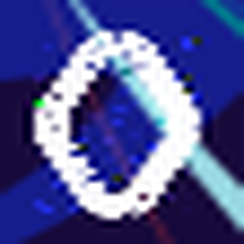

In [137]:
im = Image.open('C:\\Users\\Dinmuhametov Salavat\\Desktop\\ak_bars\\crreal\\val\\o\\0r3vl3.png')
display(im)
tsfm = data_transforms['val'](im)

In [237]:
test = pd.DataFrame(columns=['card_number', 'date_expire', 'filename', 'first_name', 'last_name'])
test_path = 'C:\\Users\\Dinmuhametov Salavat\\Desktop\\ak_bars\\real\\test\\'

In [238]:
for i in range(300):
    print('predict ', str(i) + ' of 300', i/300)
    img = Image.open(test_path+str(i)+'.png')
    x, y = img.size
    box = number_box
    card_digits = crop(img.crop((int(x*box['xl']), int(y*box['yu']), int(x*box['xr']), int(y*box['yd']))), 4, 4)
    card_number = predict_images(card_digits)
    
    box = date_box
    date_digits =crop(img.crop((int(x*box['xl']), int(y*box['yu']), int(x*box['xr']), int(y*box['yd']))), 5, 1)
    date_numbers = predict_images(date_digits)
    ldate = list(date_numbers)
    ldate[2] = '/'
    date_numbers = "".join(ldate)
    
    box = name_box
    name_char = crop(img.crop((int(x*box['xl']), int(y*box['yu']), int(x*box['xr']), int(y*box['yd']))), 13, 1)
    name = predict_images(name_char)
    
    box = fname_box
    fname_char = crop(img.crop((int(x*box['xl']), int(y*box['yu']), int(x*box['xr']), int(y*box['yd']))), 13, 1)
    fname = predict_images(fname_char)
    
#     print('creating dateframe')
#     pred = pd.DataFrame(data = [[card_number], [date_numbers], [str(i)+'.png'], [parse_name(name)],[parse_name(fname)]], columns=['card_number', 'date_expire', 'filename', 'first_name', 'last_name'])
# #     pred = pd.DataFrame(data={'card_number':[card_number], 'date_expire':[date_numbers], 'filename':[str(i)+'.png'], 'first_name':[parse_name(name)], 'last_name':[parse_name(fname)]})
    
#     print('append', pred.head())
#     test.append(pred, ignore_index=True)
    test.loc[len(test)] = [card_number, date_numbers, str(i)+'.png', parse_name(name), parse_name(fname)]

predict  0 of 300 0.0
predict  1 of 300 0.0033333333333333335
predict  2 of 300 0.006666666666666667
predict  3 of 300 0.01
predict  4 of 300 0.013333333333333334
predict  5 of 300 0.016666666666666666
predict  6 of 300 0.02
predict  7 of 300 0.023333333333333334
predict  8 of 300 0.02666666666666667
predict  9 of 300 0.03
predict  10 of 300 0.03333333333333333
predict  11 of 300 0.03666666666666667
predict  12 of 300 0.04
predict  13 of 300 0.043333333333333335
predict  14 of 300 0.04666666666666667
predict  15 of 300 0.05
predict  16 of 300 0.05333333333333334
predict  17 of 300 0.056666666666666664
predict  18 of 300 0.06
predict  19 of 300 0.06333333333333334
predict  20 of 300 0.06666666666666667
predict  21 of 300 0.07
predict  22 of 300 0.07333333333333333
predict  23 of 300 0.07666666666666666
predict  24 of 300 0.08
predict  25 of 300 0.08333333333333333
predict  26 of 300 0.08666666666666667
predict  27 of 300 0.09
predict  28 of 300 0.09333333333333334
predict  29 of 300 0.0

KeyboardInterrupt: 

In [234]:
test.head()

,card_number,date_expire,filename,first_name,last_name
0,6008821065422827,11/19,0.png,volt,adiad
1,7120613216687772,04/19,1.png,franceshi,kingley
2,5584257085087350,02/20,2.png,terpstra,bouloukos
3,1868459928864512,07/19,3.png,abimelec,kauhanenl
4,1340360178000974,12/20,4.png,montagne,gannettil


In [197]:
print(card_number, date_numbers, parse_name(name), parse_name(fname))

7120613216687772 04o19 franceshi kingley


In [166]:
def get_label_from_predict(out):
    label, mxvl = 0, 0
    for i in range(36):
        if mxvl < out[0][i].item():
            mxvl = out[0][i].item()
            label = i
    return alpabet[label]

In [162]:
def crop(image, cx, cy):
    image = image.copy()
    x, y = image.size
    dx, dy = int(x/cx), int(y/cy)
    cim = []
    for i in range(cy):  
        for j in range(cx):
            cim.append(image.crop((j*dx, i*dy, dx*(j+1), dy*(i+1))))
            cim[-1] = cim[-1].resize((244, 244),Image.ANTIALIAS)
    return cim

number_box = {'xl': 0.06, 'xr':0.325, 'yu':0.165, 'yd':0.44}
date_box = {'xl':0.09, 'xr':0.31, 'yu':0.46, 'yd':0.5}
name_box = {'xl':0.06, 'xr':0.69, 'yu':0.563, 'yd':0.605}
fname_box = {'xl':0.06, 'xr':0.69, 'yu':0.625, 'yd':0.667}
im_size = 244

In [189]:
def predict_images(ims):
    prediction = ''
    for k in range(len(ims)):
        ims[k] = data_transforms['val'](ims[k])
        shitpredict = torch.tensor([[ims[k].numpy()[0], ims[k].numpy()[1], ims[k].numpy()[2]]])
        out = model_ft(shitpredict)
        prediction += get_label_from_predict(out)
    return prediction

In [138]:
shitepredict = torch.tensor([[tsfm.numpy()[0], tsfm.numpy()[1], tsfm.numpy()[2]]])

In [191]:
def parse_name(name):
    for i in range(len(name)):
        if name[i] in '0123456789':
            return name[0:i]
    return name

In [139]:
out = model_ft(shitepredict)

In [140]:
label, mxvl = 0, 0
for i in range(36):
    if mxvl < out[0][i].item():
        print(i)
        mxvl = out[0][i].item()
        label = i

0
8
12
13
24


In [141]:
alpabet = '-0123456789abcdefghijklmnopqrstuvwxyz'

In [142]:
alpabet[label]

'o'